### Imports

In [2]:
import pandas as pd
import torch
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from torch_geometric.utils.convert import to_networkx
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit, MultilabelStratifiedKFold
# set max num of rows and cols to display
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

### Read the pre-proceesed data

In [3]:
df_all_se = pd.read_csv('../../prep_data/drug_all_se_pubchem.csv')
df_all_se.head()

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,CID000000119,"['C0002792', 'C0030193', 'C0151828', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.0630,103.0630,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."
1,CID000000137,"['C0406834', 'C0027497', 'C0019080', 'C0267792...",79,137,131.13,C5H9NO3,80.4,121.0,-3.8,9,2,4,4,"InChI=1S/C5H9NO3/c6-3-4(7)1-2-5(8)9/h1-3,6H2,(...",C(CC(=O)O)C(=O)CN,C(CC(=O)O)C(=O)CN,ZGXJTSGNIOSYLO-UHFFFAOYSA-N,5-amino-4-oxopentanoic acid,131.0580,131.0580,0,1,0,0,0,0,0,0,0,12437,14305,4919,2D+3D,Aminolevulinic Acid,Biological Test Results|Chemical and Physical ...,14,1511|1554|1662|1663|1672|1813|1814|1832|1850|1...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN
2,CID000000175,"['C0018965', 'C0020488', 'C0001122', 'C0030193']",4,175,59.04,C2H3O2-,40.1,25.5,0.4,4,0,2,0,"InChI=1S/C2H4O2/c1-2(3)4/h1H3,(H,3,4)/p-1",CC(=O)[O-],CC(=O)[O-],QTBSBXVTEAMEQO-UHFFFAOYSA-M,acetate,59.0133,59.0133,-1,1,0,0,0,0,0,0,0,44665,2166,1375,2D+3D,Acetates,Biological Test Results|Classification|Drug an...,11,1803442,20040916,AAA Chemistry|ABI Chem|AKos Consulting & Solut...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,CID000000187,"['C0010038', 'C0010037', 'C0428977', 'C0020458...",7,187,146.21,C7H16NO2+,26.3,115.0,0.2,10,0,2,4,"InChI=1S/C7H16NO2/c1-7(9)10-6-5-8(2,3)4/h5-6H2...",CC(=O)OCC[N+](C)(C)C,CC(=O)OCC[N+](C)(C)C,OIPILFWXSMYKGL-UHFFFAOYSA-N,2-acetyloxyethyl(trimethyl)azanium,146.1180,146.1180,1,1,0,0,0,0,0,0,0,68145,84896,26608,2D+3D,Acetylcholine,Biological Test Results|Chemical and Physical ...,12,423|880|1030|1457|1458|1460|1463|1468|1469|147...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."
4,CID000000206,"['C0546817', 'C0039231', 'C0030193', 'C0013604...",38,206,180.16,C6H12O6,110.0,151.0,-2.6,12,5,6,1,InChI=1S/C6H12O6/c7-1-2-3(8)4(9)5(10)6(11)12-2...,C(C1C(C(C(C(O1)O)O)O)O)O,C(C1C(C(C(C(O1)O)O)O)O)O,WQZGKKKJIJFFOK-UHFFFAOYSA-N,"6-(hydroxymethyl)oxane-2,3,4,5-tetrol",180.0630,180.0630,0,1,0,5,0,5,0,0,0,1761,14422,5588,2D+3D,NaN,Biological Test Results|Chemical and Physical ...,8,155|157|161|165|167|175|192|248|256|328|880|88...,20050325,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,NaN


In [4]:
# embeddings = torch.rand((100, 16), dtype=torch.float)
# rows = np.random.choice(100, 500)
# cols = np.random.choice(100, 500)
# edges = torch.tensor([rows, cols])
# print(edges.shape)

In [5]:
((2061 - 91) / 2061) * 100

95.58466763706939

In [6]:
df_all_se['se_count'].mean()

97.92684766214178

### Create ID mapping for stitch id and meddra term for side-effect

In [7]:
print(df_all_se['STITCH ID STEREO'].shape, df_all_se['STITCH ID STEREO'].nunique())

(1326,) 1326


In [8]:
from rdkit import Chem

#### Drug id to idx

In [9]:
STITCH_TO_ID_DICT = {id: idx for idx, id in enumerate(df_all_se['STITCH ID STEREO'])}
ID_TO_STITCH_DICT = {v: k for k, v in STITCH_TO_ID_DICT.items()}

In [10]:
drug_id_mol_graph_tup = [(id, Chem.MolFromSmiles(smiles.strip())) for id, smiles in zip(df_all_se['STITCH ID STEREO'], df_all_se['canonicalsmiles'])]
drug_to_mol_graph = {id:Chem.MolFromSmiles(smiles.strip()) for id, smiles in  zip(df_all_se['STITCH ID STEREO'], df_all_se['canonicalsmiles'])}

RDKit WARNING: [11:52:45] WARNING: not removing hydrogen atom without neighbors
[11:52:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:45] WARNING: not removing hydrogen atom without neighbors
[11:52:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [11:52:45] WARNING: not removing hydrogen atom without neighbors
[11:52:45] WARNING: not removing hydrogen atom without neighbors
[11:52:45] WARNING: not removing hydrogen atom without neighbors


#### Side effect id to idx

In [11]:
# Create a flattened list of unique meddra term concept id
column_list = df_all_se['MEDRA TERM UMLS CONCEPT ID'].tolist()
unique_values = list(set([item for sublist in column_list for item in eval(sublist)]))
MEDRAID_TO_ID_DICT = {id: idx for idx, id in enumerate(unique_values)}
ID_TO_MEDRAID_DICT = {v: k for k, v in MEDRAID_TO_ID_DICT.items()}

#### Unique Bond Type

In [12]:
# get all unique bond_type from mol_graph
bond_type_set = set()
for mol_graph in drug_to_mol_graph.values():
    bond_type_set.update([b.GetBondType() for b in mol_graph.GetBonds()])
bond_type_set = list(bond_type_set)
bond_type_set.sort()
bond_type_set = bond_type_set + ['head']
print(bond_type_set)


[rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType.DOUBLE, rdkit.Chem.rdchem.BondType.TRIPLE, rdkit.Chem.rdchem.BondType.AROMATIC, 'head']


### Pyg Graph Data Components

In [13]:
# target multi-label multi-class encoding
def all_of_k_encoding_unk(x, allowable_set):
    enc = np.zeros(len(allowable_set))
    for idx, side_eff_id in enumerate(allowable_set):
        if side_eff_id in x:
            enc[idx] = 1
    return enc
# Feature one-hot encoding
def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


In [14]:
def atom_features(atom,
                explicit_H=True,
                use_chirality=False):

    results = one_of_k_encoding_unk(
        atom.GetSymbol(),
        ['C','N','O', 'S','F','Si','P', 'Cl','Br','Mg','Na','Ca','Fe','As','Al','I','B','V','K','Tl',
            'Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn','H', 'Li','Ge','Cu','Au','Ni','Cd','In',
            'Mn','Zr','Cr','Pt','Hg','Pb','Unknown'
        ]) + [atom.GetDegree()/10, atom.GetImplicitValence(), 
                atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
                ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if explicit_H:
        results = results + [atom.GetTotalNumHs()]

    if use_chirality:
        try:
            results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]

    results = np.array(results).astype(np.float32)

    return torch.from_numpy(results) # torch.rand_like()

def get_mol_edge_list_and_feat_mtx(mol_graph, use_head_node=False, head_node_feat=None):
    n_features = [(atom.GetIdx(), atom_features(atom)) for atom in mol_graph.GetAtoms()]
    n_features.sort() # to make sure that the feature matrix is aligned according to the idx of the atom
    _, n_features = zip(*n_features)
    n_features = torch.stack(n_features)
    edge_list = torch.LongTensor([(b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol_graph.GetBonds()])
    edge_attr = torch.FloatTensor([one_of_k_encoding_unk(b.GetBondType(), bond_type_set) for b in mol_graph.GetBonds()])
    undirected_edge_list = torch.cat([edge_list, edge_list[:, [1, 0]]], dim=0) if len(edge_list) else edge_list 
    undirected_edge_attr = torch.cat([edge_attr, edge_attr], dim=0) if len(edge_attr) else edge_attr

    if use_head_node:
    
        atm_num = len(n_features)
        
        if head_node_feat=='mean':
            average_row = torch.mean(n_features, dim=0)
        elif head_node_feat=='sum':
            average_row = torch.sum(n_features, dim=0)
        else:
            # random like average_row
            average_row = torch.rand_like(average_row)
        
        # Expand dimensions to match the shape of n_features
        average_row = torch.unsqueeze(average_row, 0)
        # Concatenate the average row with n_features
        n_features_with_head = torch.cat((n_features, average_row), dim=0)

        head_edges = torch.LongTensor([(atm_num, i) for i in range(atm_num)])
        edge_attr_head_edges = torch.FloatTensor([one_of_k_encoding_unk('head', bond_type_set) for i in range(atm_num)])
        
        undirected_head_edges = torch.cat([head_edges, head_edges[:, [1, 0]]], dim=0) if len(head_edges) else head_edges
        undirected_edge_attr_head_edges = torch.cat([edge_attr_head_edges, edge_attr_head_edges], dim=0) if len(edge_attr_head_edges) else edge_attr_head_edges
        
        undirected_edge_list_all = torch.cat([undirected_edge_list, undirected_head_edges], dim=0) if len(undirected_head_edges) else undirected_edge_list
        undirected_edge_attr_all = torch.cat([undirected_edge_attr, undirected_edge_attr_head_edges], dim=0) if len(undirected_edge_attr_head_edges) else undirected_edge_attr

        return undirected_edge_list_all.T, n_features_with_head, undirected_edge_attr_all
    
    return undirected_edge_list.T, n_features, undirected_edge_attr


#### Molecular Graph Atom Node Featurizer

In [15]:
edge_list, n_feature, edge_attr = get_mol_edge_list_and_feat_mtx(mol_graph)

In [16]:
print(f'shape of edge_list: {edge_list.shape}, shape of n_feature: {n_feature.shape}, shape of edge_attr: {edge_attr.shape}')

shape of edge_list: torch.Size([2, 430]), shape of n_feature: torch.Size([214, 55]), shape of edge_attr: torch.Size([430, 5])


#### Set values require for encoding

In [17]:
# # Gettings information and features of atoms
# ATOM_MAX_NUM = np.max([m[1].GetNumAtoms() for m in drug_id_mol_graph_tup])
# AVAILABLE_ATOM_SYMBOLS = list({a.GetSymbol() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)})
# AVAILABLE_ATOM_DEGREES = list({a.GetDegree() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)})
# AVAILABLE_ATOM_TOTAL_HS = list({a.GetTotalNumHs() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)})
# max_valence = max(a.GetImplicitValence() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup))
# max_valence = max(max_valence, 9)
# AVAILABLE_ATOM_VALENCE = np.arange(max_valence + 1)

# MAX_ATOM_FC = abs(np.max([a.GetFormalCharge() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)]))
# MAX_ATOM_FC = MAX_ATOM_FC if MAX_ATOM_FC else 0
# MAX_RADICAL_ELC = abs(np.max([a.GetNumRadicalElectrons() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_id_mol_graph_tup)]))
# MAX_RADICAL_ELC = MAX_RADICAL_ELC if MAX_RADICAL_ELC else 0

#### Generate Pyg Data for each drug in SIDER

In [18]:
MOL_EDGE_LIST_FEAT_MTX = {drug_id: get_mol_edge_list_and_feat_mtx(mol) 
                                for drug_id, mol in drug_id_mol_graph_tup}

MOL_EDGE_LIST_FEAT_MTX = {drug_id: mol for drug_id, mol in MOL_EDGE_LIST_FEAT_MTX.items() if mol is not None}

TOTAL_ATOM_FEATS = (next(iter(MOL_EDGE_LIST_FEAT_MTX.values()))[1].shape[-1])

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/aten/src/ATen/native/TensorShape.cpp:2981.)


In [19]:
len(drug_id_mol_graph_tup), len(MOL_EDGE_LIST_FEAT_MTX.keys())

(1326, 1326)

#### Plot distribution of SIDEEFFECT MEDRA ID

In [20]:
cid_ctr = Counter([stichid for mlmc in column_list for stichid in eval(mlmc)])

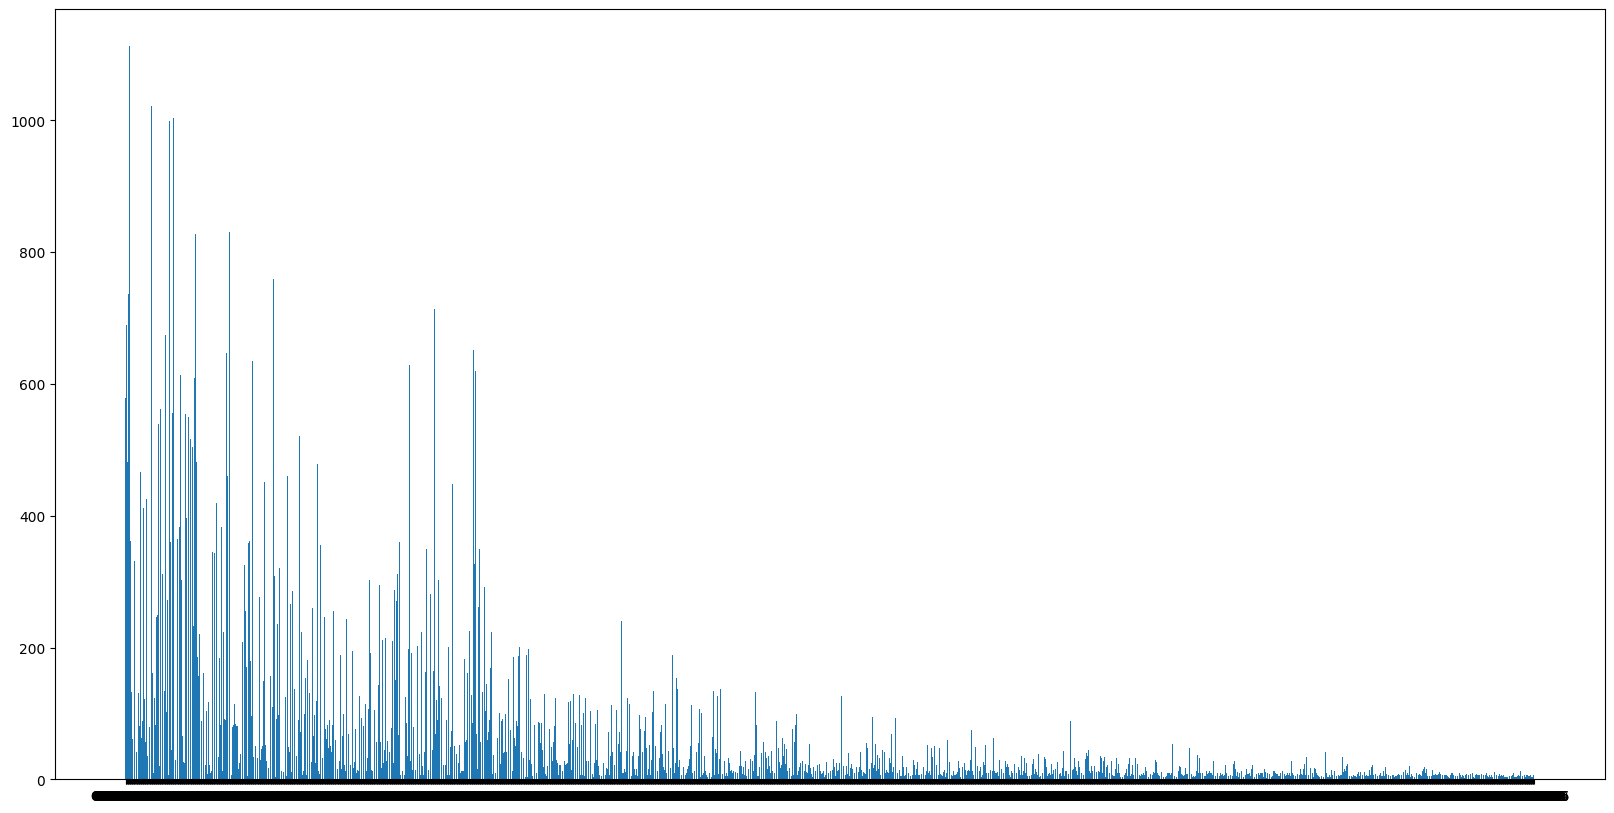

In [21]:
# plot bar chart of all the side-effect
plt.figure(figsize=(20, 10))
plt.bar(cid_ctr.keys(), cid_ctr.values())
plt.show()

In [22]:
unique_values.sort()

In [23]:
unique_values[:5]

['C0000727', 'C0000731', 'C0000737', 'C0000768', 'C0000786']

In [24]:
print(len(unique_values), unique_values[:5])

2061 ['C0000727', 'C0000731', 'C0000737', 'C0000768', 'C0000786']


### Data Distribution and split

In [25]:
import random
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Usage example:
seed_everything(42)  # Set the seed to 42


##### Stratified Split - Using SIDER Drug STITCH ID Multi-label Multi-class

In [26]:
X = df_all_se['STITCH ID STEREO'].values
y = np.stack(df_all_se['MEDRA TERM UMLS CONCEPT ID'].apply(lambda x: all_of_k_encoding_unk(eval(x), unique_values)))

In [27]:
# Split data into training (60%), validation (20%), and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Visualize Data Split y distribution - train

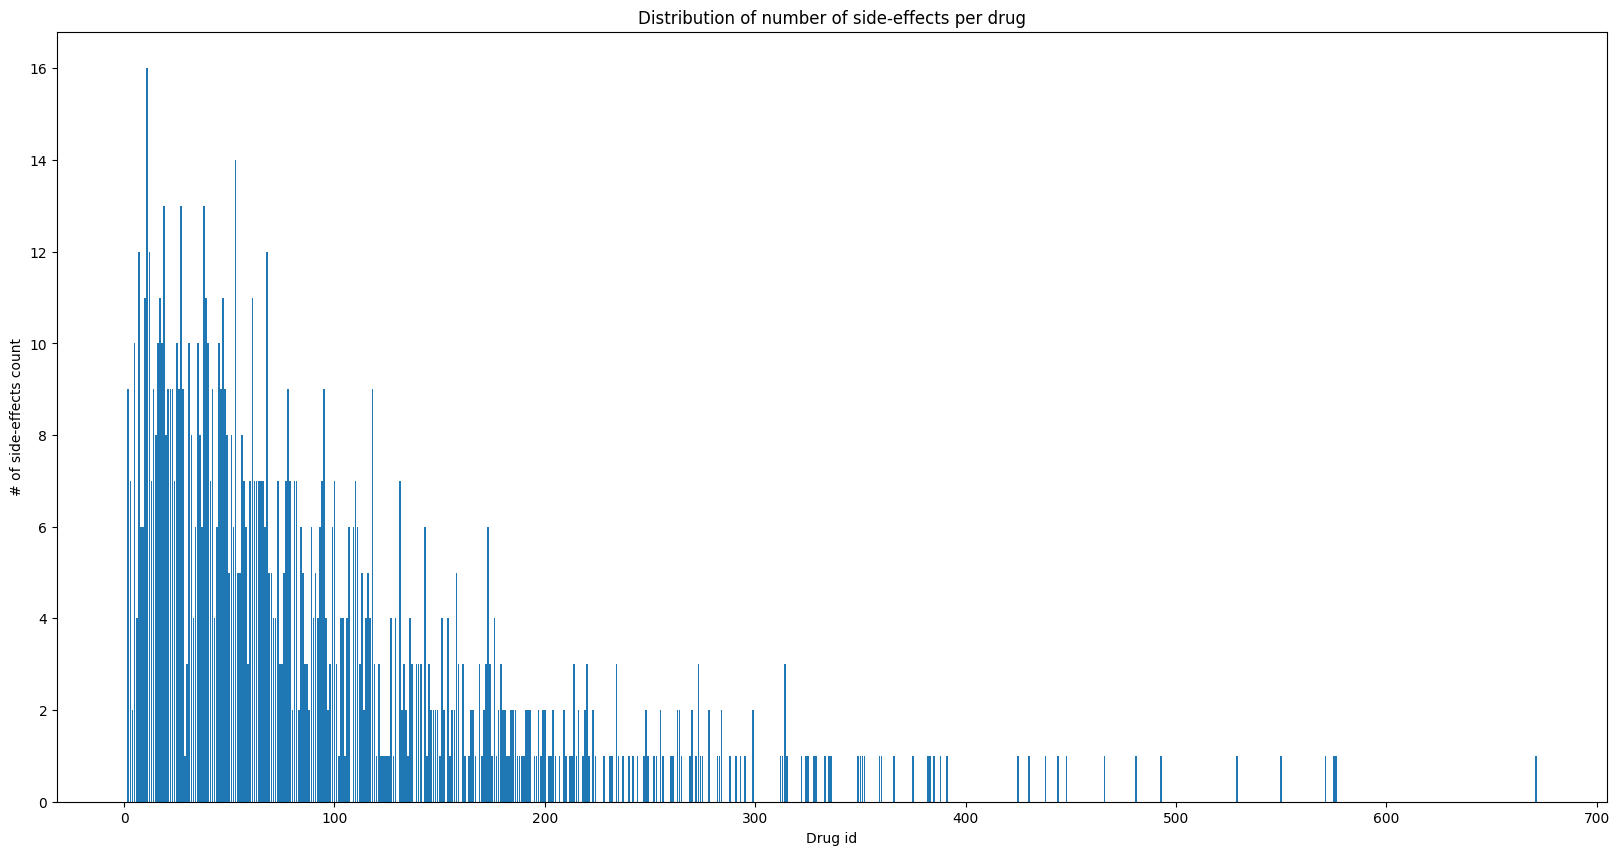

In [28]:
# plot y  distribution such as count of 1 per row
plt.figure(figsize=(20, 10))
plt.bar(*zip(*Counter(y_train.sum(axis=1)).items()))
plt.title('Distribution of number of side-effects per drug')
plt.xlabel('Drug id')
plt.ylabel('# of side-effects count')
plt.show()

#### Visualize Data Split y distribution - test

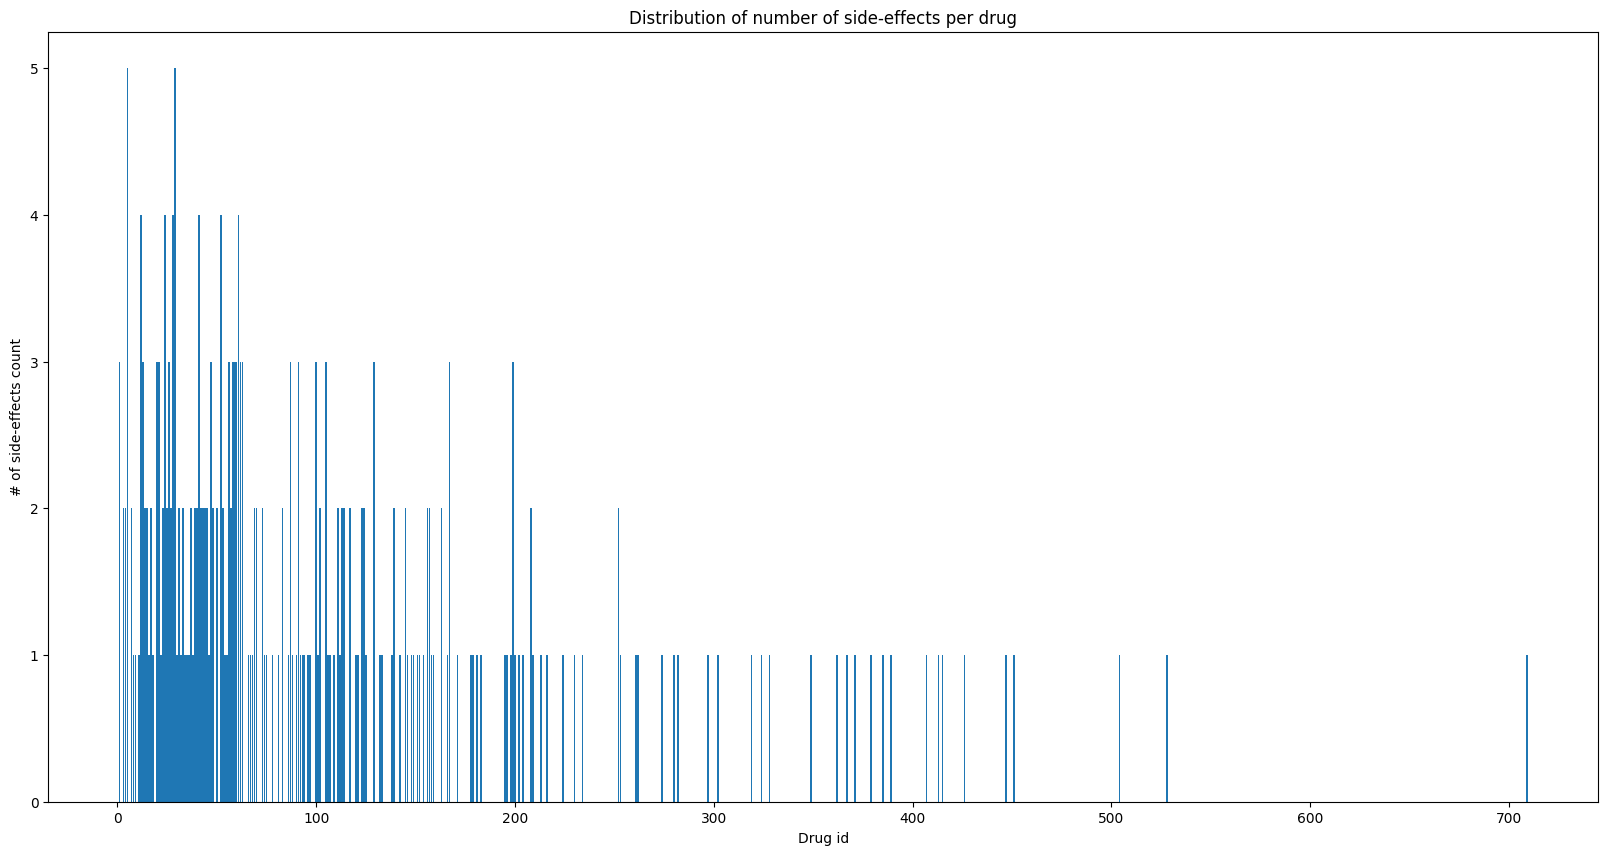

In [29]:
# plot y  distribution such as count of 1 per row
plt.figure(figsize=(20, 10))
plt.bar(*zip(*Counter(y_test.sum(axis=1)).items()))
plt.title('Distribution of number of side-effects per drug')
plt.xlabel('Drug id')
plt.ylabel('# of side-effects count')
plt.show()

#### MultilabelStratifiedShuffleSplit

In [30]:
def split_train_valid(X, y, fold, val_ratio=0.2):
    cv_split = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=val_ratio, random_state=fold)
    train_index, val_index = next(iter(cv_split.split(X=X, y=y)))
    X_train = X[train_index]
    y_train = y[train_index]
    X_val = X[val_index]
    y_val = y[val_index]
    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_ratio, random_state=fold)
    return X_train, y_train, X_val, y_val

#### MultilabelStratifiedKFold

In [31]:
def ksplit_train_valid(X, y, num_folds, val_ratio=0.2):
    mskf = MultilabelStratifiedKFold(n_splits=num_folds, random_state=0, shuffle=True)
    folds = []
    for train_index, val_index in mskf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        folds.append((X_train, y_train, X_val, y_val))
    return folds

#### K-split using MultilabelStratifiedKFold

In [32]:
folds = ksplit_train_valid(X_train, y_train, num_folds=5, val_ratio=0.2)

#### Train-Test split using MultilabelStratifiedShuffleSplit

In [33]:
X_train, y_train, X_val, y_val = split_train_valid(X_train, y_train, 1)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (808,), y_train: (808, 2061), X_val: (252,), y_val: (252, 2061), X_test: (266,), y_test: (266, 2061)


#### Create train, val, test data 

In [34]:
train_tup = list(zip(X_train, y_train))
val_tup = list(zip(X_val, y_val))
test_tup = list(zip(X_test, y_test))

In [35]:
train_tup[0]

('CID000003278', array([0., 0., 0., ..., 0., 0., 0.]))

In [36]:
# randsplit_df = pd.DataFrame({
#     'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train.values, order=2) for combination in row),
#     'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test.values, order=2) for combination in row)
# }).T.fillna(0.0)
# sort the columns
# randsplit_df = randsplit_df.reindex(sorted(randsplit_df.columns), axis=1)
# randsplit_df.head()
# start_df = pd.DataFrame({
#     'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=2) for combination in row),
#     'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=2) for combination in row)
# }).T.fillna(0.0)
# randsplit_df[start_df.columns].head()

#### All drug ids

In [37]:
ALL_DRUG_IDS, _ = zip(*drug_id_mol_graph_tup)
ALL_DRUG_IDS = np.array(list(set(ALL_DRUG_IDS)))

In [38]:
ALL_DRUG_IDS

array(['CID000125017', 'CID000002160', 'CID011672461', ...,
       'CID000006238', 'CID006918140', 'CID000004034'], dtype='<U12')

### Pyg Custom Dataset

In [39]:
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import math

In [40]:
class DrugDataset(Dataset):
    def __init__(self, data_tup, ratio=1.0,  neg_ent=1, disjoint_split=True, shuffle=True):
        ''''disjoint_split: Consider whether entities should appear in one and only one split of the dataset
        ''' 
        self.neg_ent = neg_ent # not using now multi-label multi-class do not need this
        self.data_tup = []
        self.ratio = ratio
        
        for h, se in data_tup:
            if (h in MOL_EDGE_LIST_FEAT_MTX):
                self.data_tup.append((h,se))
        if disjoint_split:
            d1, *_ = zip(*self.data_tup)
            self.drug_ids = np.array(list(set(d1)))
        else:
            self.drug_ids = ALL_DRUG_IDS

        self.drug_ids = np.array([id for id in self.drug_ids if id in MOL_EDGE_LIST_FEAT_MTX])
        
        if shuffle:
            random.shuffle(self.data_tup)
        limit = math.ceil(len(self.data_tup) * ratio)
        self.data_tup = self.data_tup[:limit]
  
    def __len__(self):
        return len(self.data_tup)
    
    def __getitem__(self, index):
        return self.data_tup[index]

    def collate_fn(self, batch):
        
        h_samples = []
        h_se_samples = []
        
        for h, se in batch:
            h_data = self.__create_graph_data(h)
            h_samples.append(h_data)
            h_se_samples.append(se)
        
        h_samples = Batch.from_data_list(h_samples)
        h_se_samples = torch.LongTensor(h_se_samples)

        return h_samples, h_se_samples
    
    # def __create_side_eff_labels(self, id):
    #     return SIDE_EFFECT_LABELS[id]

    def __create_graph_data(self, id):
        edge_index = MOL_EDGE_LIST_FEAT_MTX[id][0]
        n_features = MOL_EDGE_LIST_FEAT_MTX[id][1]
        edge_attr = MOL_EDGE_LIST_FEAT_MTX[id][2]  
        return Data(x=n_features, edge_index=edge_index, edge_attr=edge_attr)
    
    # def _create_b_graph(self,edge_index,x_s, x_t):
    #     return BipartiteData(edge_index,x_s,x_t)
    ### neg sampling strategy ###
    # def __corrupt_ent(self, other_ent, r, other_ent_with_r_dict, max_num=1):
    #     corrupted_ents = []
    #     current_size = 0
    #     while current_size < max_num:
    #         candidates = np.random.choice(self.drug_ids, (max_num - current_size) * 2)
    #         mask = np.isin(candidates, other_ent_with_r_dict[(other_ent, r)], assume_unique=True, invert=True)
    #         corrupted_ents.append(candidates[mask])
    #         current_size += len(corrupted_ents[-1])
        
    #     if corrupted_ents != []:
    #         corrupted_ents = np.concatenate(corrupted_ents)

    #     return np.asarray(corrupted_ents[:max_num])
        
    # def __corrupt_head(self, t, r, n=1):
    #     return self.__corrupt_ent(t, r, ALL_TRUE_H_WITH_TR, n)

    # def __corrupt_tail(self, h, r, n=1):
    #     return self.__corrupt_ent(h, r, ALL_TRUE_T_WITH_HR, n)
    
    # def __normal_batch(self, h, t, r, neg_size):
    #     neg_size_h = 0
    #     neg_size_t = 0
    #     prob = ALL_TAIL_PER_HEAD[r] / (ALL_TAIL_PER_HEAD[r] + ALL_HEAD_PER_TAIL[r])
    #     for i in range(neg_size):
    #         if random.random() < prob:
    #             neg_size_h += 1
    #         else:
    #             neg_size_t +=1
        
    #     return (self.__corrupt_head(t, r, neg_size_h),
    #             self.__corrupt_tail(h, r, neg_size_t))  


### Pyg DataLoader

In [41]:
class DrugDataLoader(DataLoader):
    def __init__(self, data, **kwargs):
        super().__init__(data, collate_fn=data.collate_fn, **kwargs)

### Create Pyg Dataset using split 

In [42]:
train_data = DrugDataset(train_tup, ratio=1, neg_ent=1)
val_data = DrugDataset(val_tup, ratio=1, neg_ent=1)
test_data = DrugDataset(test_tup, ratio=1, neg_ent=1)

### Create Pyg Dataloader using pyg dataset

In [79]:
print(f"Training with {len(train_data)} samples, validating with {len(val_data)}, and testing with {len(test_data)}")

train_data_loader = DrugDataLoader(train_data, batch_size=64, shuffle=True,num_workers=2)
val_data_loader = DrugDataLoader(val_data, batch_size=64,num_workers=2)
test_data_loader = DrugDataLoader(test_data, batch_size=64 *3,num_workers=2)
    

Training with 837 samples, validating with 223, and testing with 266


#### Sample view pyg Data

In [44]:
X, y = next(iter(train_data_loader))

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/torch/csrc/utils/tensor_new.cpp:201.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/torch/csrc/utils/tensor_new.cpp:201.)


In [45]:
X

DataBatch(x=[2125, 55], edge_index=[2, 4428], edge_attr=[4428, 5], batch=[2125], ptr=[65])

In [46]:
y, y.shape

(tensor([[0, 0, 1,  ..., 1, 0, 0],
         [0, 1, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 1, 0, 0],
         [0, 0, 0,  ..., 1, 0, 0]]),
 torch.Size([64, 2061]))

In [47]:
for step,( X,y) in enumerate(train_data_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {y.shape[0]}')
    print(X)
    print()

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/torch/csrc/utils/tensor_new.cpp:201.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/torch/csrc/utils/tensor_new.cpp:201.)


Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1970, 55], edge_index=[2, 4138], edge_attr=[4138, 5], batch=[1970], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[1947, 55], edge_index=[2, 4104], edge_attr=[4104, 5], batch=[1947], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[1790, 55], edge_index=[2, 3756], edge_attr=[3756, 5], batch=[1790], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[2193, 55], edge_index=[2, 4620], edge_attr=[4620, 5], batch=[2193], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[1994, 55], edge_index=[2, 4198], edge_attr=[4198, 5], batch=[1994], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[1793, 55], edge_index=[2, 3780], edge_attr=[3780, 5], batch=[1793], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[1984, 55], edge_index=[2, 4168], edge_attr=[4168, 5], batch=[1984], ptr=[65])

Step 8

### Model Loss

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, input, target):
        # Flatten the input and target tensors
        input = input.view(-1)
        target = target.view(-1)

        intersection = torch.sum(input * target)
        cardinality = torch.sum(input) + torch.sum(target)

        dice_loss = 1 - (2 * intersection + self.smooth) / (cardinality + self.smooth)

        return dice_loss


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, pt, target):
        
        
        loss = -self.alpha * (1 - pt) ** self.gamma * target * torch.log(pt + 1e-20) - \
               (1 - self.alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt + 1e-20)
        
        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


In [52]:
import torch
import torch.nn.functional as F

def symmetric_cross_entropy_loss(outputs, targets, alpha=0.1, beta=1.0):
    batch_size = outputs.size(0)
    num_classes = outputs.size(1)
    
    # Compute the Cross Entropy loss
    ce_loss = F.binary_cross_entropy_with_logits(outputs, targets)
    
    # Compute the Reverse Cross Entropy loss
    reverse_ce_loss = F.binary_cross_entropy_with_logits(targets, outputs)
    
    # Compute the Symmetric Cross Entropy loss
    sce_loss = alpha * ce_loss + beta * reverse_ce_loss
    
    return sce_loss

# Example usage
# outputs = torch.randn(32, 10)  # Output logits from the model
# targets = torch.randn(32, 10)  # Target labels (can be one-hot encoded or raw logits)

# loss = symmetric_cross_entropy_loss(outputs, targets, alpha=0.1, beta=1.0)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.5, gamma=2, reduction='mean'):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, input, target):
#         pt = torch.sigmoid(input)
#         loss = -self.alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
#                (1 - self.alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt)

#         if self.reduction == 'mean':
#             loss = loss.mean()
#         elif self.reduction == 'sum':
#             loss = loss.sum()

#         return loss


In [ ]:
# import torch
# import torch.nn.functional as F

# def adaptive_logarithmic_loss(outputs, targets, alpha=0.7, gamma=5.0, epsilon=1e-7):
#     batch_size = outputs.size(0)
#     num_classes = outputs.size(1)
    
#     # Apply sigmoid activation to the outputs
#     outputs = torch.sigmoid(outputs)
    
#     # Compute the per-class weights
#     targets_sum = targets.sum(dim=0)
#     targets_weight = (1.0 - alpha) / (targets_sum + epsilon)  # Add epsilon for numerical stability
    
#     # Compute the Logarithmic Loss
#     log_loss = -torch.log(outputs + epsilon) * targets * targets_weight
    
#     # Compute the Adaptive Logarithmic Loss
#     all_loss = log_loss.sum() / (batch_size * num_classes)
    
#     # Apply the focal factor to the loss
#     all_loss = torch.pow(1.0 - all_loss, gamma)
    
#     return all_loss

# # Example usage
# outputs = torch.randn(32, 10)  # Output logits from the model
# targets = torch.randn(32, 10)  # Target labels (can be one-hot encoded or raw logits)

# # loss = adaptive_logarithmic_loss(outputs, targets, alpha=0.5, gamma=2.0, epsilon=1e-7)


### Pyg Model - using single head gat - 3 gatv2conv

In [54]:
from torch.nn import Linear, Sequential
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv, GATConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        # torch.manual_seed(12345)
        self.conv1 = GATv2Conv(num_node_features, hidden_channels, edge_dim=5)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels,  edge_dim=5)
        self.conv3 = GATv2Conv(hidden_channels, hidden_channels,  edge_dim=5)
        self.lin = Sequential(Linear(3*hidden_channels, hidden_channels), nn.ReLU(), Linear(hidden_channels, num_classes), nn.Sigmoid())            
        self.batchnorm1 = torch.nn.BatchNorm1d(num_node_features)
        self.batchnorm2 = torch.nn.BatchNorm1d(hidden_channels)
        self.batchnorm3 = torch.nn.BatchNorm1d(hidden_channels)      

    def forward(self, x, edge_index, edge_attr, batch):
        head_nodes = []
        #to-do: check this logic. I intended to pick last atom which should be head node frpm batches
        # Find the indices of the last node in each batch
        unique_batches = torch.unique(batch)
        last_indices = torch.zeros_like(unique_batches)
        for i, b in enumerate(unique_batches):
            last_indices[i] = (batch == b).nonzero().max()
        
        x = self.batchnorm1(x)
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = self.batchnorm2(x)
        x = x.relu()
        head_nodes.append(x[last_indices])
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        x = self.batchnorm3(x)
        x = x.relu()
        head_nodes.append(x[last_indices])
        x = self.conv3(x, edge_index, edge_attr=edge_attr)
        
        
        head_nodes.append(x[last_indices])
        head_nodes = torch.cat(head_nodes, dim=1)
        # # 2. Readout layer
        # x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(head_nodes, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


#### Forward logic to pick the head node from the batch
Note: Here batch contains number of drugs with each drug represented as atoms and bonds and hence batch.x shape

In [76]:
train_data_loader = DrugDataLoader(train_data, batch_size=64, shuffle=True,num_workers=2)

In [90]:
batch, y = next(iter(train_data_loader))

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/torch/csrc/utils/tensor_new.cpp:201.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/torch/csrc/utils/tensor_new.cpp:201.)


In [83]:
y.shape

torch.Size([64, 2061])

In [88]:
batch

DataBatch(x=[1760, 55], edge_index=[2, 3712], edge_attr=[3712, 5], batch=[1760], ptr=[65])

In [69]:
print(batch.batch.shape)
batch.batch

torch.Size([2102])


tensor([ 0,  0,  0,  ..., 63, 63, 63])

In [91]:
unique_batches = torch.unique(batch.batch)
unique_batches

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [92]:
last_indices = torch.zeros_like(unique_batches)
last_indices

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
for i, b in enumerate(unique_batches):
    last_indices[i] = (batch.batch == b).nonzero().max()

In [97]:
last_indices[1]

tensor(67)

In [99]:
batch.x[67]

tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000,
        1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        1.0000])

In [98]:
batch.batch[67]

tensor(1)

In [100]:
batch.batch[68]

tensor(2)

### Pyg Model - using multi head gat - 3 gatv2conv

In [55]:
from torch.nn import Linear, Sequential, ModuleList
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv, GATConv
from torch_geometric.nn import global_mean_pool, LayerNorm
import torch

class GCNv2(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, heads_out_feat_params, blocks_params, num_classes):
        super(GCNv2, self).__init__()
        self.blocks_params = blocks_params
        self.initial_norm = LayerNorm(num_node_features)
        self.n_blocks = len(blocks_params)
        self.blocks = []
        self.net_norms = ModuleList()
        for i, (head_out_feats, n_heads) in enumerate(zip(heads_out_feat_params, blocks_params)):
            block = GATv2Conv(num_node_features, head_out_feats, n_heads,  edge_dim=5)
            self.add_module(f'block{i}', block)
            self.blocks.append(block)
            self.net_norms.append(LayerNorm(head_out_feats*n_heads))
            num_node_features = n_heads * head_out_feats
        # self.head_feat_comb = Sequential(Linear(3*hidden_channels, hidden_channels), nn.ReLU())
        self.head_norm = LayerNorm(hidden_channels)
        
        self.lin = Sequential(Linear(3*hidden_channels, 2*hidden_channels), nn.ReLU(), Linear(2*hidden_channels, num_classes), nn.Sigmoid())            
        # glorot initialize self.lin weight
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)



    def forward(self, x, edge_index, edge_attr, batch):
        head_nodes = []
        # Find the indices of the last node in each batch
        unique_batches = torch.unique(batch)
        last_indices = torch.zeros_like(unique_batches)
        for i, b in enumerate(unique_batches):
            last_indices[i] = (batch == b).nonzero().max()
        
        out = self.initial_norm(x)
        out = F.dropout(out, p=0.5, training=self.training)
        # 1. Obtain node embeddings 
        for i, block in enumerate(self.blocks):
            out = block(out, edge_index, edge_attr)
            # print(out.shape)
            out = self.net_norms[i](out)
            out = out.relu()
            head_node = out[last_indices]
            head_node = head_node.view(head_node.shape[0],self.blocks_params[i], -1).sum(dim=1)
            head_node = self.head_norm(head_node)
            # head_node = head_node.view(head_node.shape[0],self.blocks_params[i], -1)
            # attention = torch.softmax(head_node, dim=1)
            # weighted_head_node = head_node * attention
            # head_node = torch.sum(weighted_head_node, dim=1)
            head_nodes.append(head_node)
            


        # x = self.conv1(x, edge_index)
        # x = self.batchnorm2(x)
        # x = x.relu()
        # head_nodes.append(x[last_indices])
        # x = self.conv2(x, edge_index)
        # x = self.batchnorm3(x)
        # x = x.relu()
        # head_nodes.append(x[last_indices])
        # x = self.conv3(x, edge_index)
        
        
        # head_nodes.append(x[last_indices])
        head_nodes = torch.cat(head_nodes, dim=1)
        
        # # 2. Readout layer
        # x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(head_nodes, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


### Main method to train test and compute eval metrics for GCN

In [57]:
from sklearn import metrics

def do_compute_metrics(probas_pred, target):            
    pred = (probas_pred >= 0.5).astype(int)
    acc = metrics.accuracy_score(target, pred)
    auroc = metrics.roc_auc_score(target, probas_pred)
    f1_score = metrics.f1_score(target, pred)
    precision = metrics.precision_score(target, pred)
    recall = metrics.recall_score(target, pred)
    p, r, t = metrics.precision_recall_curve(target, probas_pred)
    int_ap = metrics.auc(r, p)
    ap = metrics.average_precision_score(target, probas_pred)

    return acc, auroc, f1_score, precision, recall, int_ap, ap


In [58]:
# from torch import optim

# model = GCNv2(num_node_features=55, hidden_channels=256, heads_out_feat_params=[256, 256, 256], blocks_params=[3, 3, 3], num_classes=2061)
# print(model)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
# # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# loss = DiceLoss(smooth=1e-5) # torch.nn.BCEWithLogitsLoss() # FocalLoss(alpha=0.5, gamma=2) torch.nn.BCELoss() # 
# n_epochs = 100
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=0.00001)
# # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.96 ** (epoch))
# scheduler = None
# pkl_name = 'gcn_se_model_withedge.pkl'

# model.to(device=device)

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def test(test_data_loader,model):
    test_probas_pred = []
    test_ground_truth = []
    model.eval()
    with torch.no_grad():
        for batch, y in test_data_loader:
            
            batch = batch.to(device)
            y = y.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_attr , batch.batch)
            probas_pred = out.detach().flatten().cpu()
            ground_truth = y.flatten().float().cpu()
            test_probas_pred.append(probas_pred)
            test_ground_truth.append(ground_truth)
            
        test_probas_pred = np.concatenate(test_probas_pred)
        test_ground_truth = np.concatenate(test_ground_truth)
        
        test_acc, test_auc_roc, test_f1, test_precision,test_recall,test_int_ap, test_ap = do_compute_metrics(test_probas_pred, test_ground_truth)
                                                                                         
    print('\n')
    print('============================== Test Result ==============================')
    print(f'\t\ttest_acc: {test_acc:.4f}, test_auc_roc: {test_auc_roc:.4f},test_f1: {test_f1:.4f},test_precision:{test_precision:.4f}')
    print(f'\t\ttest_recall: {test_recall:.4f}, test_int_ap: {test_int_ap:.4f},test_ap: {test_ap:.4f}')
    # Clear intermediate variables to free CUDA memory
    del batch
    torch.cuda.empty_cache()      

In [51]:
from datetime import datetime
import time

def train(pkl_name, model, train_data_loader, val_data_loader, loss_fn, optimizer, n_epochs, device, scheduler=None):
    max_acc = 0
    print('Starting training at', datetime.today())
    for i in range(1, n_epochs+1):
        start = time.time()
        train_loss = 0
        val_loss = 0
        train_probas_pred = []
        train_ground_truth = []
        
        val_probas_pred = []
        val_ground_truth = []
      
        for batch, y in train_data_loader:
            model.train()
            batch = batch.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            train_probas_pred.append(out.detach().flatten().cpu())
            train_ground_truth.append(y.flatten().float().cpu())
            loss = loss_fn(out, y.float())
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * len(y)
        
        train_loss /= len(train_data)
        
        with torch.no_grad():
            train_probas_pred = np.concatenate(train_probas_pred)
            train_ground_truth = np.concatenate(train_ground_truth)
            
            train_acc, train_auc_roc, train_f1_score, train_precision, train_recall, train_int_ap, train_ap = do_compute_metrics(train_probas_pred, train_ground_truth)
            
            for batch, y in val_data_loader:
                model.eval()
                batch = batch.to(device)
                y = y.to(device)
                out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
                val_probas_pred.append(out.detach().flatten().cpu())
                val_ground_truth.append(y.flatten().float().cpu())
                loss = loss_fn(out, y.float())
                val_loss += loss.item() * len(y)
            
            val_loss /= len(val_data)
            val_probas_pred = np.concatenate(val_probas_pred)
            val_ground_truth = np.concatenate(val_ground_truth)
            
            val_acc, val_auc_roc, val_f1, val_precision,val_recall,val_int_ap, val_ap = do_compute_metrics(val_probas_pred, val_ground_truth)
            if val_auc_roc>max_acc:
                max_acc = val_auc_roc
                torch.save(model, pkl_name)
               
        if scheduler:
            # print('scheduling')
            scheduler.step(val_f1) #val_loss
            # Get the current learning rate
            current_lr = optimizer.param_groups[0]['lr'] 

        print(f'Epoch: {i} ({time.time() - start:.4f}s), train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f},'
        f' train_acc: {train_acc:.4f}, val_acc:{val_acc:.4f}')
        print(f'\t\ttrain_auc_roc: {train_auc_roc:.4f}, val_auc_roc: {val_auc_roc:.4f}, train_ap: {train_ap:.4f}, val_ap: {val_ap:.4f}, \
              train_f1_score: {train_f1_score:.4f}, val_f1_score: {val_f1:.4f}, train_precision: {train_precision:.4f}, val_precision: {val_precision:.4f}')
        if i % 5 == 0:
            # Clear intermediate variables to free CUDA memory
            del batch
            torch.cuda.empty_cache()


### Single fold split model train and test

In [58]:

import warnings
from contextlib import redirect_stdout

X = df_all_se['STITCH ID STEREO'].values
y = np.stack(df_all_se['MEDRA TERM UMLS CONCEPT ID'].apply(lambda x: all_of_k_encoding_unk(eval(x), unique_values)))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train, y_train, X_val, y_val = split_train_valid(X_train, y_train, 1)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_val.shape}, y_val: {y_val.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}')

train_tup = list(zip(X_train, y_train))
val_tup = list(zip(X_val, y_val))
test_tup = list(zip(X_test, y_test))

train_data = DrugDataset(train_tup, ratio=1, neg_ent=1)
val_data = DrugDataset(val_tup, ratio=1, neg_ent=1)
test_data = DrugDataset(test_tup, ratio=1, neg_ent=1)

print(f"Training with {len(train_data)} samples, validating with {len(val_data)}, and testing with {len(test_data)}")

train_data_loader = DrugDataLoader(train_data, batch_size=64, shuffle=True,num_workers=2)
val_data_loader = DrugDataLoader(val_data, batch_size=64,num_workers=2)
test_data_loader = DrugDataLoader(test_data, batch_size=64 *3,num_workers=2)
    
report_singleF = "report_singleFWBondFeat.txt"
print(f'Running for single fold')
from torch import optim

model = GCNv2(num_node_features=55, hidden_channels=128, heads_out_feat_params=[128, 128, 128], blocks_params=[3, 3, 3], num_classes=2061)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss = symmetric_cross_entropy_loss #nn.MultiLabelSoftMarginLoss() # DiceLoss(smooth=1e-5) # torch.nn.BCEWithLogitsLoss() # FocalLoss(alpha=0.5, gamma=2) torch.nn.BCELoss() # 
n_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=0.00001)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.96 ** (epoch))
# scheduler = None

pkl_name = f'gcn_se_model_singleFWBondFeat.pkl'

model.to(device=device)


with warnings.catch_warnings():
    # with open(report_singleF, 'a') as f:
    #     with redirect_stdout(f):
    warnings.filterwarnings("ignore")
    train(pkl_name, model, train_data_loader, val_data_loader, loss, optimizer, n_epochs, device, scheduler)
    model = torch.load(pkl_name)
    test(test_data_loader,model)
    torch.cuda.empty_cache()
    

X_train: (837,), y_train: (837, 2061), X_val: (223,), y_val: (223, 2061), X_test: (266,), y_test: (266, 2061)
Training with 837 samples, validating with 223, and testing with 266
Running for single fold
GCNv2(
  (initial_norm): LayerNorm(55, affine=True, mode=graph)
  (net_norms): ModuleList(
    (0): LayerNorm(384, affine=True, mode=graph)
    (1): LayerNorm(384, affine=True, mode=graph)
    (2): LayerNorm(384, affine=True, mode=graph)
  )
  (block0): GATv2Conv(55, 128, heads=3)
  (block1): GATv2Conv(384, 128, heads=3)
  (block2): GATv2Conv(384, 128, heads=3)
  (head_norm): LayerNorm(128, affine=True, mode=graph)
  (lin): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2061, bias=True)
    (3): Sigmoid()
  )
)
Starting training at 2023-08-18 11:59:05.257972
Epoch: 1 (5.8377s), train_loss: 0.7875, val_loss: 0.7746, train_acc: 0.6247, val_acc:0.8178
		train_auc_roc: 0.7180, val_auc_roc: 0.8357, train

In [175]:
test(test_data_loader,model)



============================== Test Result ==============================
		test_acc: 0.9345, test_auc_roc: 0.8377,test_f1: 0.3836,test_precision:0.3390
		test_recall: 0.4417, test_int_ap: 0.3077,test_ap: 0.3072


### 5 fold split model train and test

In [65]:
import warnings
X = df_all_se['STITCH ID STEREO'].values
y = np.stack(df_all_se['MEDRA TERM UMLS CONCEPT ID'].apply(lambda x: all_of_k_encoding_unk(eval(x), unique_values)))
from contextlib import redirect_stdout
from sklearn.model_selection import train_test_split
# Split data into training (60%), validation (20%), and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
test_tup = list(zip(X_test, y_test))
test_data = DrugDataset(test_tup, ratio=1, neg_ent=1)
test_data_loader = DrugDataLoader(test_data, batch_size=64 *3,num_workers=2)
    
report = "report_bond_5Fold.txt"
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    for fold, (X_train, y_train, X_val, y_val) in enumerate(ksplit_train_valid(X_train, y_train, 5)):
        train_tup = list(zip(X_train, y_train))
        val_tup = list(zip(X_val, y_val))
        
        train_data = DrugDataset(train_tup, ratio=1, neg_ent=1)
        val_data = DrugDataset(val_tup, ratio=1, neg_ent=1)
        
        print(f"Training with {len(train_data)} samples, validating with {len(val_data)}, and testing with {len(test_data)}")

        train_data_loader = DrugDataLoader(train_data, batch_size=64, shuffle=True,num_workers=2)
        val_data_loader = DrugDataLoader(val_data, batch_size=64,num_workers=2)
        
        
        print(f'Running for Fold {fold}')
        from torch import optim

        model = GCNv2(num_node_features=55, hidden_channels=64, heads_out_feat_params=[64, 64, 64], blocks_params=[3, 3, 3], num_classes=2061)
        print(model)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
        # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        loss = DiceLoss(smooth=1e-5) # torch.nn.BCEWithLogitsLoss() # FocalLoss(alpha=0.5, gamma=2) torch.nn.BCELoss() # 
        n_epochs = 50
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=0.00001)
        # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.96 ** (epoch))
        scheduler = None
        pkl_name = f'gcn_se_model_bond_{fold}.pkl'

        model.to(device=device)
        # pass the print statements to a file
        with open(report, 'a') as f:
            with redirect_stdout(f):
                print(f'Running for Fold {fold}')
                train(pkl_name, model, train_data_loader, val_data_loader, loss, optimizer, n_epochs, device, scheduler)
                test(test_data_loader, model)
        # Clear intermediate variables to free CUDA memory
        del train_data_loader, val_data_loader, train_data, val_data, X_train, y_train, X_val, y_val, train_tup, val_tup
        

        del model 
        torch.cuda.empty_cache()

Training with 852 samples, validating with 208, and testing with 266
Running for Fold 0
GCNv2(
  (initial_norm): LayerNorm(55)
  (net_norms): ModuleList(
    (0): LayerNorm(192)
    (1): LayerNorm(192)
    (2): LayerNorm(192)
  )
  (block0): GATv2Conv(55, 64, heads=3)
  (block1): GATv2Conv(192, 64, heads=3)
  (block2): GATv2Conv(192, 64, heads=3)
  (head_norm): LayerNorm(64)
  (lin): Sequential(
    (0): Linear(in_features=192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2061, bias=True)
    (3): Sigmoid()
  )
)
Training with 850 samples, validating with 210, and testing with 266
Running for Fold 1
GCNv2(
  (initial_norm): LayerNorm(55)
  (net_norms): ModuleList(
    (0): LayerNorm(192)
    (1): LayerNorm(192)
    (2): LayerNorm(192)
  )
  (block0): GATv2Conv(55, 64, heads=3)
  (block1): GATv2Conv(192, 64, heads=3)
  (block2): GATv2Conv(192, 64, heads=3)
  (head_norm): LayerNorm(64)
  (lin): Sequential(
    (0): Linear(in_features=192, out

In [84]:
test(test_data_loader, model)



============================== Test Result ==============================
		test_acc: 0.9346, test_auc_roc: 0.8276,test_f1: 0.4111,test_precision:0.3920
		test_recall: 0.4321, test_int_ap: 0.3155,test_ap: 0.3155


### Different model cached print result for comparision

In [82]:
test(test_data_loader,model.to(device))



============================== Test Result ==============================
		test_acc: 0.9346, test_auc_roc: 0.8276,test_f1: 0.4111,test_precision:0.3920
		test_recall: 0.4321, test_int_ap: 0.3155,test_ap: 0.3155


In [170]:
test(test_data_loader,model.to(device))

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)




============================== Test Result ==============================
		test_acc: 0.9489, test_auc_roc: 0.8596,test_f1: 0.1071,test_precision:0.7624
		test_recall: 0.0576, test_int_ap: 0.3644,test_ap: 0.3644


In [ ]:
# ============================== Test Result ==============================
# test_acc: 0.9489, test_auc_roc: 0.8552,test_f1: 0.1073,test_precision:0.7604
# test_recall: 0.0577, test_int_ap: 0.3606,test_ap: 0.3606

### Using untrained model and baseline metrics

In [120]:
model_untrained = GCN(num_node_features=55, hidden_channels=128, num_classes=2061)


In [171]:
test(test_data_loader,model_untrained.to(device))

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisio



============================== Test Result ==============================
		test_acc: 0.9468, test_auc_roc: 0.5271,test_f1: 0.0000,test_precision:0.0000
		test_recall: 0.0000, test_int_ap: 0.0586,test_ap: 0.0586


In [119]:
test(val_data_loader,model)

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)




============================== Test Result ==============================
		test_acc: 0.9528, test_auc_roc: 0.8614,test_f1: 0.1125,test_precision:0.7399
		test_recall: 0.0609, test_int_ap: 0.3517,test_ap: 0.3517


In [117]:
test(train_data_loader,model)

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)




============================== Test Result ==============================
		test_acc: 0.9567, test_auc_roc: 0.8702,test_f1: 0.1199,test_precision:0.7274
		test_recall: 0.0653, test_int_ap: 0.3483,test_ap: 0.3483


In [122]:
test(train_data_loader,model_untrained.to(device))

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_divisio



============================== Test Result ==============================
		test_acc: 0.9549, test_auc_roc: 0.5161,test_f1: 0.0000,test_precision:0.0000
		test_recall: 0.0000, test_int_ap: 0.0472,test_ap: 0.0472


In [116]:
test(test_data_loader,model)

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)




============================== Test Result ==============================
		test_acc: 0.9489, test_auc_roc: 0.8552,test_f1: 0.1073,test_precision:0.7604
		test_recall: 0.0577, test_int_ap: 0.3606,test_ap: 0.3606
